In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

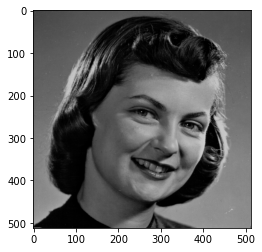

In [2]:
img = cv2.imread("GirlFace.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Part 1

## 1.1 Histogram
- Download the Girl Face image 
- Plot a histogram of the grey levels it contains. (Try plotting a histogram of another grey scale image and comparing the difference)
##### 5 points

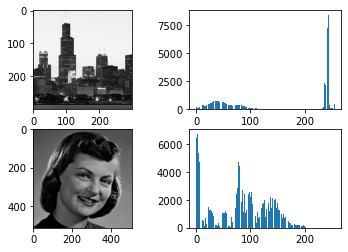

In [45]:
def createHistogram(image):
    values = np.zeros(256)
    n = image.shape[0]
    m = image.shape[1]
    for i in range(0,n):
        for j in range(0,m):
            values[image[i,j]] += 1
    return values

city = cv2.imread("../../images/cityscapes.jpg")
imgVals = createHistogram(city)

#image 1
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(city, cv2.COLOR_BGR2RGB))
#plot 1
plt.subplot (2, 2, 2)
plt.bar(range(len(imgVals)), imgVals)
#image 2
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plot 2
plt.subplot(2, 2, 4)
imgVals = createHistogram(img)
plt.bar(range(len(imgVals)), imgVals)
plt.show()

## 1.2 Threshold 
- Write a short program to threshold the image and try to identify a good threshold by trial and
error. 
- Create a ground truth segmentation. 
        Ground truths are “true and accurate” segmentations that are typically made by one or more human experts.
#### 15 points

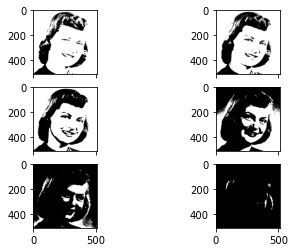

Ground Truth Segmentation. Using 0.27 as threshold between 0 and 1


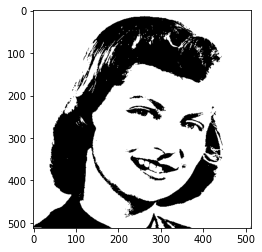

In [3]:
def ApplyThreshold(img, t):
    a = np.average(np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2])), axis = 1)
    a = a / max(a)
    return np.reshape(a < t, (img.shape[0], img.shape[1], 1))
trialAndError = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
f, s = plt.subplots((len(trialAndError) + 1)//2, 2, sharex='col')
for i, t in enumerate(trialAndError):
    s[i // 2, i % 2].imshow(ApplyThreshold(img, t), cmap = 'binary')
plt.show()
groundTruthThreshold = 0.27
print("Ground Truth Segmentation. Using", groundTruthThreshold, "as threshold between 0 and 1")
groundTruthImage = ApplyThreshold(img, groundTruthThreshold)
plt.imshow(groundTruthImage, cmap = 'binary')
plt.show()

## 1.3 ROC Curve
- Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm. 
    
     `What threshold does the ROC curve suggest?`
        Note: You may have to implement an algorithm to find the point closest to a desired Operating Point. 
    `How does it compare to your trial and error estimate?`
#### 30 points

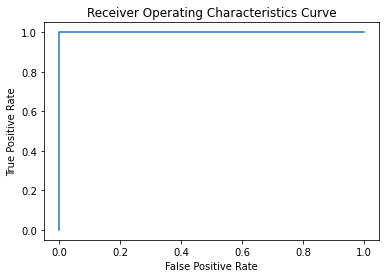

In [4]:
# True positive rate
#    The higher TPR, the fewer positive data points we will miss.
def TPR(groundTruth, estimation): 
    tp = sum(sum(np.logical_and(groundTruthImage, estimation)))
    differ = np.logical_xor(estimation, groundTruthImage)
    fn = sum(sum(np.logical_and(differ, groundTruth)))
    if tp + fn == 0: return 0
    return tp/(tp + fn)
# False positive rate
#    The higher FPR, the more negative data points will be missclassified
def FPR(groundTruth, estimation): 
    tn = sum(sum(np.logical_not(np.logical_or(groundTruthImage, estimation))))
    differ = np.logical_xor(estimation, groundTruthImage)
    fp = sum(sum(np.logical_and(differ, estimation)))
    if fp + tn == 0: return 0
    return fp/(fp + tn)
thresholds = np.arange(0, 1, 0.01)
TPRs, FPRs = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for i, t in enumerate(thresholds):
    estimation = ApplyThreshold(img, t)
    #print(i, TPR(groundTruthImage, estimation), FPR(groundTruthImage, estimation))
    TPRs[i] = TPR(groundTruthImage, estimation)
    FPRs[i] = FPR(groundTruthImage, estimation)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristics Curve")
plt.plot(FPRs, TPRs)

# Part 2

## 2.1 Region growing algorithm 
- Implement a region growing algorithm 
- Compare its performance at segmenting the face in the image above with the performance of the thresholding algorithm.
- Show the seeds you chose.
#### (25 points)

## 2.2 Mean-shift algorithm
- Implement the mean-shift algorithm.
- Show the results that you achieve for different values of the 'radius' parameter.
#### 25 points

# Detailed report
- Point out your process, thoughts and outcomes.